Idee:
Hier wurde geprüft ob es möglich ist nur mit der Thresholdmaske das Signal zu entdecken

Ausgangssituation:
Gibt es klare Abgrenzungen der Graustufen, so dass nichts helles hinter einem weissen Signal bzw. dunkles hinter einem schwarzen Signal ist. So ist es möglich das Signal zu finden.

In [1]:
# OpenCV needs to be included first
import cv2
import numpy as np

# for displaying images in jupyter

import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline
# resolution of images in figure
mpl.rcParams['figure.dpi']= 200
# figure size in inchesz
mpl.rcParams["figure.figsize"] = [10,5]

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# load the image on disk and then display it
image = cv2.imread('images/my-pic8_w-h-iso100-light-exauto.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

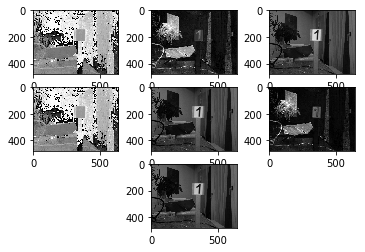

In [3]:
hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
hsv_h,hsv_s,hsv_v = cv2.split(hsv)
hls_h,hls_l,hls_s = cv2.split(hls)
plt.subplot(3, 3, 1)
plt.imshow(hsv_h, cmap='gray')
plt.subplot(3, 3, 2)
plt.imshow(hsv_s, cmap='gray')
plt.subplot(3, 3, 3)
plt.imshow(hsv_v, cmap='gray')
plt.subplot(3, 3, 4)
plt.imshow(hls_h, cmap='gray')
plt.subplot(3, 3, 5)
plt.imshow(hls_l, cmap='gray')
plt.subplot(3, 3, 6)
plt.imshow(hls_s, cmap='gray')
plt.subplot(3, 3, 8)
plt.imshow(gray, cmap='gray')

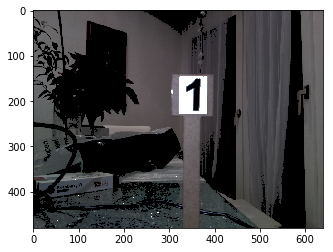

In [4]:
threshold_map = hsv_v <= 50

image[threshold_map] = [0, 0, 0]
image[gray > 150] = [255, 255, 255]

plt.imshow(image)

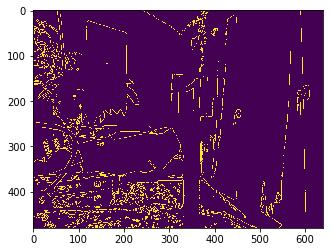

In [5]:
# Find edges in the image using canny edge detection method
# Calculate lower threshold and upper threshold using sigma = 0.33
grayscale = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

low = 40
high = 220

edged = cv2.Canny(grayscale, low, high)

plt.imshow(edged)

299 464 square 298 463 3 3
261 459 rectangle 261 459 4 2
279 458 rectangle 270 456 17 7
421 456 square 420 455 3 3
439 455 rectangle 435 452 18 12
309 453 rectangle 307 452 6 3
270 449 rectangle 269 449 3 2
317 448 square 316 447 3 3
261 448 square 260 447 3 3
424 446 rectangle 419 443 18 10
237 438 square 236 437 3 3
323 430 rectangle 319 429 12 7
308 433 rectangle 297 429 32 9
217 436 rectangle 186 427 51 16
281 418 rectangle 271 412 25 9
206 412 rectangle 206 412 2 3
248 410 rectangle 244 408 7 5
212 402 rectangle 212 401 11 5
254 399 square 253 398 3 3
264 386 rectangle 262 386 6 3
234 383 rectangle 229 382 11 4
325 382 rectangle 246 370 89 58
257 332 rectangle 254 330 7 5
326 320 rectangle 325 319 4 3
270 342 rectangle 189 318 141 67
373 292 rectangle 373 287 3 8
392 288 rectangle 388 272 13 43
301 274 rectangle 272 259 61 73
this is our square
374 323 rectangle 368 193 38 205
352 186 rectangle 321 145 65 85
this is our square
306 178 rectangle 304 141 28 43
357 60 rectangle 352 5

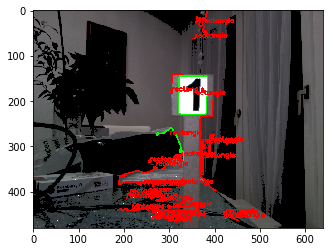

In [6]:
# After finding edges we have to find contours
# Contour is a curve of points with no gaps in the curve
# It will help us to find location of shapes

# cv2.RETR_EXTERNAL is passed to find the outermost contours (because we want to outline the shapes)
# cv2.CHAIN_APPROX_SIMPLE is removing redundant points along a line
(_, cnts, _) = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


'''
We are going to use contour approximation method to find vertices of
geometric shapes. The alogrithm  is also known as Ramer Douglas Peucker alogrithm.
In OpenCV it is implemented in cv2.approxPolyDP method.abs
detectShape() function below takes a contour as parameter and
then returns its shape
 '''


def detectShape(cnt):
    shape = 'unknown'
    # calculate perimeter using
    peri = cv2.arcLength(c, True)
    # apply contour approximation and store the result in vertices
    vertices = cv2.approxPolyDP(c, 0.04 * peri, True)

    # If the shape it triangle, it will have 3 vertices
    if len(vertices) == 3:
        shape = 'triangle'

    # if the shape has 4 vertices, it is either a square or
    # a rectangle
    elif len(vertices) == 4:
        # using the boundingRect method calculate the width and height
        # of enclosing rectange and then calculte aspect ratio

        x, y, width, height = cv2.boundingRect(vertices)
        aspectRatio = float(width) / height

        # a square will have an aspect ratio that is approximately
        # equal to one, otherwise, the shape is a rectangle
        if aspectRatio >= 0.95 and aspectRatio <= 1.05:
            shape = "square"
        else:
            shape = "rectangle"

    # if the shape is a pentagon, it will have 5 vertices
    elif len(vertices) == 5:
        shape = "pentagon"

    # otherwise, we assume the shape is a circle
    else:
        shape = "circle"

    # return the name of the shape
    return shape


# Now we will loop over every contour
# call detectShape() for it and
# write the name of shape in the center of image

# loop over the contours
for c in cnts:
    # compute the moment of contour
    M = cv2.moments(c)
    if(M['m00']!=0.0):
        # From moment we can calculte area, centroid etc
        # The center or centroid can be calculated as follows
        cX = int(M['m10'] / M['m00'])
        cY = int(M['m01'] / M['m00'])

        # call detectShape for contour c
        shape = detectShape(c)
        
        if((shape == "square" or shape == "rectangle") and cX > 200 and cX < 500) :
            
            x,y,w,h = cv2.boundingRect(c)
            
            print(cX, cY, shape, x,y,w,h)
            
            ratio = w/h

            # Outline the contours
            if(ratio > 0.75 and ratio < 1.25 and w > 10):
                cv2.drawContours(image, [c], -1, (0, 255, 0), 2)
                print('this is our square')
            else:
                cv2.drawContours(image, [c], -1, (255, 0, 0), 2)

            # Write the name of shape on the center of shapes
            cv2.putText(image, shape, (cX, cY), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

            # show the output image
            plt.imshow(image)
            
        

